# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:56 - loss: 0.6936

  31/1875 [..............................] - ETA: 3s - loss: 0.5390   

  64/1875 [>.............................] - ETA: 2s - loss: 0.4566

  96/1875 [>.............................] - ETA: 2s - loss: 0.4154

 128/1875 [=>............................] - ETA: 2s - loss: 0.3890

 154/1875 [=>............................] - ETA: 2s - loss: 0.3730

 188/1875 [==>...........................] - ETA: 2s - loss: 0.3565

 222/1875 [==>...........................] - ETA: 2s - loss: 0.3432

 256/1875 [===>..........................] - ETA: 2s - loss: 0.3320

 288/1875 [===>..........................] - ETA: 2s - loss: 0.3230

 321/1875 [====>.........................] - ETA: 2s - loss: 0.3148

 354/1875 [====>.........................] - ETA: 2s - loss: 0.3076

 388/1875 [=====>........................] - ETA: 2s - loss: 0.3009

 420/1875 [=====>........................] - ETA: 2s - loss: 0.2952

 454/1875 [======>.......................] - ETA: 2s - loss: 0.2897

 488/1875 [======>.......................] - ETA: 2s - loss: 0.2847

 521/1875 [=======>......................] - ETA: 2s - loss: 0.2802

 556/1875 [=======>......................] - ETA: 2s - loss: 0.2757

 589/1875 [========>.....................] - ETA: 2s - loss: 0.2719

 623/1875 [========>.....................] - ETA: 1s - loss: 0.2681

 658/1875 [=========>....................] - ETA: 1s - loss: 0.2645

 692/1875 [==========>...................] - ETA: 1s - loss: 0.2612

 723/1875 [==========>...................] - ETA: 1s - loss: 0.2584

 756/1875 [===========>..................] - ETA: 1s - loss: 0.2555

 789/1875 [===========>..................] - ETA: 1s - loss: 0.2528



 822/1875 [============>.................] - ETA: 1s - loss: 0.2502



 855/1875 [============>.................] - ETA: 1s - loss: 0.2477

 888/1875 [=============>................] - ETA: 1s - loss: 0.2453

 919/1875 [=============>................] - ETA: 1s - loss: 0.2432

 942/1875 [==============>...............] - ETA: 1s - loss: 0.2417

 961/1875 [==============>...............] - ETA: 1s - loss: 0.2405

 981/1875 [==============>...............] - ETA: 1s - loss: 0.2392

1009/1875 [===============>..............] - ETA: 1s - loss: 0.2375

1043/1875 [===============>..............] - ETA: 1s - loss: 0.2355

1078/1875 [================>.............] - ETA: 1s - loss: 0.2335

1112/1875 [================>.............] - ETA: 1s - loss: 0.2317

1147/1875 [=================>............] - ETA: 1s - loss: 0.2298

1182/1875 [=================>............] - ETA: 1s - loss: 0.2281

1217/1875 [==================>...........] - ETA: 1s - loss: 0.2264

1252/1875 [===================>..........] - ETA: 0s - loss: 0.2247

1287/1875 [===================>..........] - ETA: 0s - loss: 0.2231

1319/1875 [====================>.........] - ETA: 0s - loss: 0.2217

1350/1875 [====================>.........] - ETA: 0s - loss: 0.2204

1383/1875 [=====================>........] - ETA: 0s - loss: 0.2190

1417/1875 [=====================>........] - ETA: 0s - loss: 0.2176

1452/1875 [======================>.......] - ETA: 0s - loss: 0.2163

1487/1875 [======================>.......] - ETA: 0s - loss: 0.2149

1522/1875 [=======================>......] - ETA: 0s - loss: 0.2137

1550/1875 [=======================>......] - ETA: 0s - loss: 0.2126

1582/1875 [========================>.....] - ETA: 0s - loss: 0.2115

1614/1875 [========================>.....] - ETA: 0s - loss: 0.2104

1649/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1684/1875 [=========================>....] - ETA: 0s - loss: 0.2081

1719/1875 [==========================>...] - ETA: 0s - loss: 0.2070

1754/1875 [===========================>..] - ETA: 0s - loss: 0.2059

1790/1875 [===========================>..] - ETA: 0s - loss: 0.2048

1822/1875 [============================>.] - ETA: 0s - loss: 0.2039

1851/1875 [============================>.] - ETA: 0s - loss: 0.2031

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2024


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1081

  36/1875 [..............................] - ETA: 2s - loss: 0.1070

  70/1875 [>.............................] - ETA: 2s - loss: 0.1076

 105/1875 [>.............................] - ETA: 2s - loss: 0.1082

 140/1875 [=>............................] - ETA: 2s - loss: 0.1085

 174/1875 [=>............................] - ETA: 2s - loss: 0.1087

 210/1875 [==>...........................] - ETA: 2s - loss: 0.1088

 244/1875 [==>...........................] - ETA: 2s - loss: 0.1089

 279/1875 [===>..........................] - ETA: 2s - loss: 0.1089

 315/1875 [====>.........................] - ETA: 2s - loss: 0.1089

 343/1875 [====>.........................] - ETA: 2s - loss: 0.1089

 373/1875 [====>.........................] - ETA: 2s - loss: 0.1089

 405/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 434/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 462/1875 [======>.......................] - ETA: 2s - loss: 0.1088

 491/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 519/1875 [=======>......................] - ETA: 2s - loss: 0.1087

 552/1875 [=======>......................] - ETA: 2s - loss: 0.1087

 583/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 614/1875 [========>.....................] - ETA: 1s - loss: 0.1086

 642/1875 [=========>....................] - ETA: 1s - loss: 0.1085

 675/1875 [=========>....................] - ETA: 1s - loss: 0.1084

 709/1875 [==========>...................] - ETA: 1s - loss: 0.1084

 744/1875 [==========>...................] - ETA: 1s - loss: 0.1083

 773/1875 [===========>..................] - ETA: 1s - loss: 0.1083

 804/1875 [===========>..................] - ETA: 1s - loss: 0.1082

 834/1875 [============>.................] - ETA: 1s - loss: 0.1082

 867/1875 [============>.................] - ETA: 1s - loss: 0.1081

 902/1875 [=============>................] - ETA: 1s - loss: 0.1080

 935/1875 [=============>................] - ETA: 1s - loss: 0.1080

 966/1875 [==============>...............] - ETA: 1s - loss: 0.1079

 999/1875 [==============>...............] - ETA: 1s - loss: 0.1078

1032/1875 [===============>..............] - ETA: 1s - loss: 0.1078

1065/1875 [================>.............] - ETA: 1s - loss: 0.1077

1098/1875 [================>.............] - ETA: 1s - loss: 0.1076

1131/1875 [=================>............] - ETA: 1s - loss: 0.1076

1164/1875 [=================>............] - ETA: 1s - loss: 0.1075

1198/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1231/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1264/1875 [===================>..........] - ETA: 0s - loss: 0.1073

1297/1875 [===================>..........] - ETA: 0s - loss: 0.1072

1329/1875 [====================>.........] - ETA: 0s - loss: 0.1072

1361/1875 [====================>.........] - ETA: 0s - loss: 0.1071

1394/1875 [=====================>........] - ETA: 0s - loss: 0.1070

1428/1875 [=====================>........] - ETA: 0s - loss: 0.1070

1463/1875 [======================>.......] - ETA: 0s - loss: 0.1069

1497/1875 [======================>.......] - ETA: 0s - loss: 0.1069

1525/1875 [=======================>......] - ETA: 0s - loss: 0.1068

1554/1875 [=======================>......] - ETA: 0s - loss: 0.1068

1583/1875 [========================>.....] - ETA: 0s - loss: 0.1067

1611/1875 [========================>.....] - ETA: 0s - loss: 0.1067

1646/1875 [=========================>....] - ETA: 0s - loss: 0.1066

1680/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1714/1875 [==========================>...] - ETA: 0s - loss: 0.1065

1746/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1779/1875 [===========================>..] - ETA: 0s - loss: 0.1064

1812/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1845/1875 [============================>.] - ETA: 0s - loss: 0.1063

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1062


Epoch 3/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0994

  32/1875 [..............................] - ETA: 3s - loss: 0.0993

  65/1875 [>.............................] - ETA: 2s - loss: 0.0991

  97/1875 [>.............................] - ETA: 2s - loss: 0.0987

 132/1875 [=>............................] - ETA: 2s - loss: 0.0986

 165/1875 [=>............................] - ETA: 2s - loss: 0.0985

 198/1875 [==>...........................] - ETA: 2s - loss: 0.0984

 232/1875 [==>...........................] - ETA: 2s - loss: 0.0984

 263/1875 [===>..........................] - ETA: 2s - loss: 0.0984

 289/1875 [===>..........................] - ETA: 2s - loss: 0.0983

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0983

 350/1875 [====>.........................] - ETA: 2s - loss: 0.0983

 383/1875 [=====>........................] - ETA: 2s - loss: 0.0983

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0983

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 479/1875 [======>.......................] - ETA: 2s - loss: 0.0982

 512/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 545/1875 [=======>......................] - ETA: 2s - loss: 0.0982

 578/1875 [========>.....................] - ETA: 2s - loss: 0.0982

 612/1875 [========>.....................] - ETA: 1s - loss: 0.0982

 644/1875 [=========>....................] - ETA: 1s - loss: 0.0982

 677/1875 [=========>....................] - ETA: 1s - loss: 0.0982

 710/1875 [==========>...................] - ETA: 1s - loss: 0.0981

 740/1875 [==========>...................] - ETA: 1s - loss: 0.0981

 770/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 802/1875 [===========>..................] - ETA: 1s - loss: 0.0981

 834/1875 [============>.................] - ETA: 1s - loss: 0.0981

 867/1875 [============>.................] - ETA: 1s - loss: 0.0981

 901/1875 [=============>................] - ETA: 1s - loss: 0.0981

 936/1875 [=============>................] - ETA: 1s - loss: 0.0981

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0981

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1094/1875 [================>.............] - ETA: 1s - loss: 0.0980

1120/1875 [================>.............] - ETA: 1s - loss: 0.0980

1151/1875 [=================>............] - ETA: 1s - loss: 0.0980

1184/1875 [=================>............] - ETA: 1s - loss: 0.0980

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1252/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1284/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1318/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1379/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1407/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1440/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0979

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1619/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1782/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1846/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0931

  36/1875 [..............................] - ETA: 2s - loss: 0.0964

  71/1875 [>.............................] - ETA: 2s - loss: 0.0966

 105/1875 [>.............................] - ETA: 2s - loss: 0.0966

 139/1875 [=>............................] - ETA: 2s - loss: 0.0967

 173/1875 [=>............................] - ETA: 2s - loss: 0.0966

 203/1875 [==>...........................] - ETA: 2s - loss: 0.0966

 237/1875 [==>...........................] - ETA: 2s - loss: 0.0965

 268/1875 [===>..........................] - ETA: 2s - loss: 0.0965

 298/1875 [===>..........................] - ETA: 2s - loss: 0.0965

 333/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 356/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 380/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 408/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 512/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 616/1875 [========>.....................] - ETA: 1s - loss: 0.0962

 650/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 682/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 716/1875 [==========>...................] - ETA: 1s - loss: 0.0961

 751/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 786/1875 [===========>..................] - ETA: 1s - loss: 0.0961

 820/1875 [============>.................] - ETA: 1s - loss: 0.0961

 853/1875 [============>.................] - ETA: 1s - loss: 0.0961

 886/1875 [=============>................] - ETA: 1s - loss: 0.0961

 919/1875 [=============>................] - ETA: 1s - loss: 0.0961

 952/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 985/1875 [==============>...............] - ETA: 1s - loss: 0.0960

1012/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0960

1068/1875 [================>.............] - ETA: 1s - loss: 0.0960

1098/1875 [================>.............] - ETA: 1s - loss: 0.0960

1131/1875 [=================>............] - ETA: 1s - loss: 0.0960

1164/1875 [=================>............] - ETA: 1s - loss: 0.0960

1197/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1230/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1264/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1298/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1333/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1366/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1430/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1719/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1817/1875 [============================>.] - ETA: 0s - loss: 0.0959

1849/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0949

  34/1875 [..............................] - ETA: 2s - loss: 0.0957

  67/1875 [>.............................] - ETA: 2s - loss: 0.0957

 100/1875 [>.............................] - ETA: 2s - loss: 0.0956

 129/1875 [=>............................] - ETA: 2s - loss: 0.0956

 158/1875 [=>............................] - ETA: 2s - loss: 0.0956

 181/1875 [=>............................] - ETA: 2s - loss: 0.0956

 213/1875 [==>...........................] - ETA: 2s - loss: 0.0955

 244/1875 [==>...........................] - ETA: 2s - loss: 0.0955

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 301/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 335/1875 [====>.........................] - ETA: 2s - loss: 0.0954

 363/1875 [====>.........................] - ETA: 2s - loss: 0.0953

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 486/1875 [======>.......................] - ETA: 2s - loss: 0.0952

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 552/1875 [=======>......................] - ETA: 2s - loss: 0.0952

 587/1875 [========>.....................] - ETA: 2s - loss: 0.0952

 621/1875 [========>.....................] - ETA: 2s - loss: 0.0952

 654/1875 [=========>....................] - ETA: 2s - loss: 0.0952

 683/1875 [=========>....................] - ETA: 1s - loss: 0.0952

 712/1875 [==========>...................] - ETA: 1s - loss: 0.0952

 743/1875 [==========>...................] - ETA: 1s - loss: 0.0952

 775/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 806/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 840/1875 [============>.................] - ETA: 1s - loss: 0.0952

 872/1875 [============>.................] - ETA: 1s - loss: 0.0952

 905/1875 [=============>................] - ETA: 1s - loss: 0.0952

 937/1875 [=============>................] - ETA: 1s - loss: 0.0952

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1025/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1056/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1085/1875 [================>.............] - ETA: 1s - loss: 0.0952

1116/1875 [================>.............] - ETA: 1s - loss: 0.0952

1150/1875 [=================>............] - ETA: 1s - loss: 0.0952

1183/1875 [=================>............] - ETA: 1s - loss: 0.0952

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1277/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1311/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1344/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1532/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1693/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1819/1875 [============================>.] - ETA: 0s - loss: 0.0952

1849/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

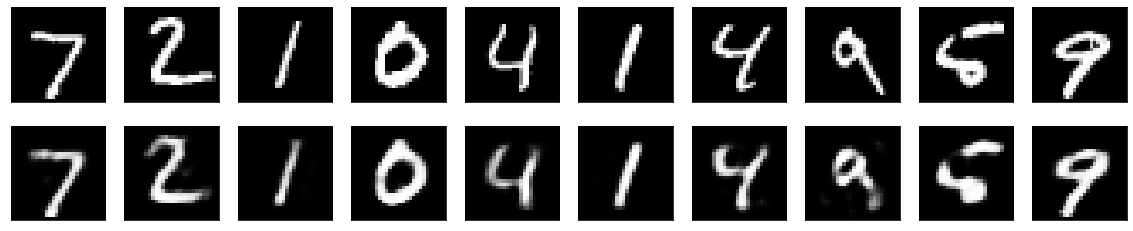

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
